In [7]:
import os
import shutil
import zipfile

# Paths to your local zip files
image_file = 'D:/Deep Learning/Images/ImageRight.zip'
annotation_file = 'D:/Deep Learning/Annotations/AnnotationsRight.zip'

# Destination directories for extracted files
data_images = 'D:/Deep Learning/Images/im'  
data_annotations = 'D:/Deep Learning/Annotations/an'

# Ensure directories exist
os.makedirs(data_images, exist_ok=True)
os.makedirs(data_annotations, exist_ok=True)

# Unzip the image file directly to destination
with zipfile.ZipFile(image_file, 'r') as zip_ref:
    zip_ref.extractall(data_images)

# Unzip the annotation file directly to destination
with zipfile.ZipFile(annotation_file, 'r') as zip_ref:
    zip_ref.extractall(data_annotations)

# ถ้าไม่ต้องการเก็บไฟล์ zip ไว้ ก็สามารถลบได้หลังจาก unzip เรียบร้อย
os.remove(image_file)
os.remove(annotation_file)


In [10]:
from collections import namedtuple
import csv
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
# import the necessary packages
from collections import namedtuple
import cv2
# define the `Detection` object for IOU(
Detection = namedtuple("Detection", ["image_path", "gt", "pred"])
from PIL import Image, ImageOps
# importing XML parsing library for parsing the data
import xml.etree.ElementTree as ET

In [13]:
# เชคจำนวนไฟล์ใน Dataset
import glob

image_files = glob.glob(data_images + '/' + '*.jpg')
print(len(image_files))

5726


In [16]:
import glob
from os.path import exists
from PIL import Image
import numpy as np
import os

TARGET_SIZE = (224, 224)

# The following function will read the text annotation file and return the values for pupil x and y coordinate
def retrieve_annotation(path_to_annotation):
    path_to_annotation = data_annotations + '/' + path_to_annotation
    file_exists = exists(path_to_annotation)
    if file_exists:
        print(f'Found annotation file: {path_to_annotation}')  # Debugging
        with open(path_to_annotation, 'r') as annotation_file:
            pupil_location = annotation_file.readline().split()
            if pupil_location != []:
                return [float(pupil_location[0]), float(pupil_location[1])]
            else:
                print(f'No pupil location data in {path_to_annotation}')  # Debugging
                return []
    else:
        print(f'Annotation file not found: {path_to_annotation}')  # Debugging
        return []

data_pros = []
image_files = glob.glob(data_images + '/*.jpg')
image_files_total = len(image_files)
print(f'Total images found: {image_files_total}')  # Debugging

for image_files_count in range(image_files_total):
    image_file = image_files[image_files_count]
    image_filename = image_file.split(os.sep)  # Changed to os.sep for compatibility
    image_filename_only = image_filename[len(image_filename) - 1].split('.jpg')
    sample_name = image_filename_only[0]

    image = Image.open(image_file)
    image_data = np.array(image.getdata()).reshape(image.size[1], image.size[0], 3)

    pupil_location = retrieve_annotation(sample_name + '.txt')
    if pupil_location != []:
        # Keep only right eye image and left pupil location
        print(f'Adding sample: {sample_name}')  # Debugging
        data_tuple = (image_data, pupil_location)
        data_pros.append(data_tuple)
    else:
        print(f'No valid annotation for image: {sample_name}')  # Debugging

print(f'Processed {len(data_pros)} samples')


Total images found: 5726
Found annotation file: D:/Deep Learning/Annotations/an/0001_2m_-15P_-10V_-10H.txt
Adding sample: 0001_2m_-15P_-10V_-10H
Found annotation file: D:/Deep Learning/Annotations/an/0001_2m_-15P_-10V_-15H.txt
Adding sample: 0001_2m_-15P_-10V_-15H
Found annotation file: D:/Deep Learning/Annotations/an/0001_2m_-15P_-10V_-5H.txt
Adding sample: 0001_2m_-15P_-10V_-5H
Found annotation file: D:/Deep Learning/Annotations/an/0001_2m_-15P_-10V_0H.txt
Adding sample: 0001_2m_-15P_-10V_0H
Found annotation file: D:/Deep Learning/Annotations/an/0001_2m_-15P_-10V_10H.txt
Adding sample: 0001_2m_-15P_-10V_10H
Found annotation file: D:/Deep Learning/Annotations/an/0001_2m_-15P_-10V_15H.txt
Adding sample: 0001_2m_-15P_-10V_15H
Found annotation file: D:/Deep Learning/Annotations/an/0001_2m_-15P_-10V_5H.txt
Adding sample: 0001_2m_-15P_-10V_5H
Found annotation file: D:/Deep Learning/Annotations/an/0001_2m_-15P_0V_-10H.txt
Adding sample: 0001_2m_-15P_0V_-10H
Found annotation file: D:/Deep Le

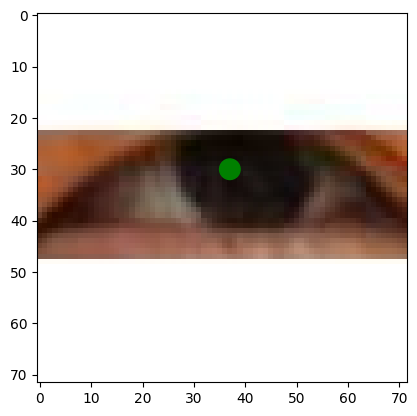

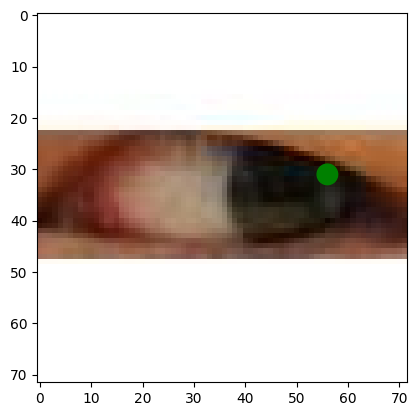

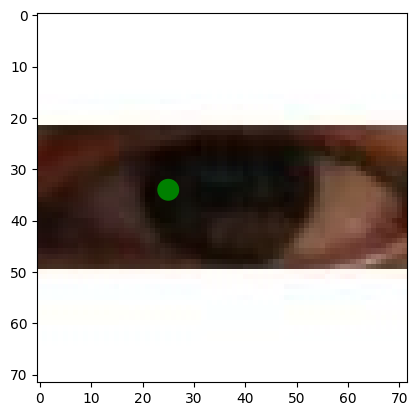

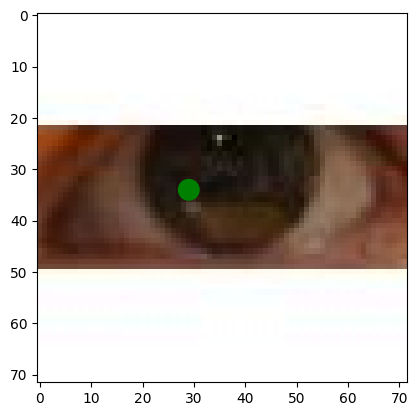

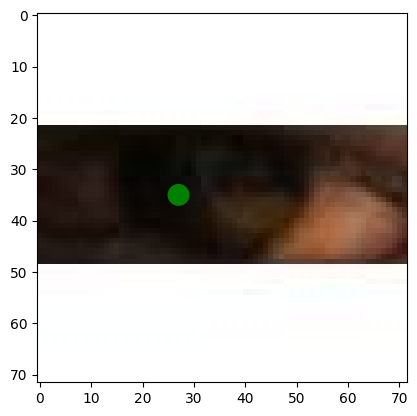

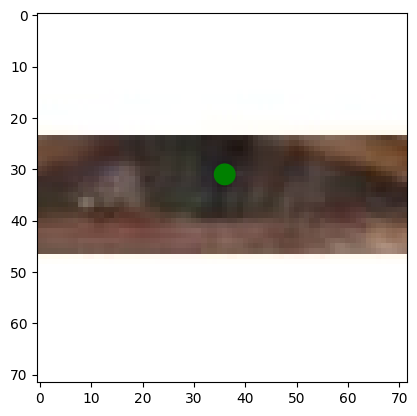

In [17]:
# ลองดู Dataset ว่าถูกต้องมั๊ย?
# ที่ถูกต้องต้องมีจุดเขียวอยู่ประมาณกลางตาดำ
from matplotlib import pyplot as patches
# For checking lets print 6 eye images along with their pupil locations
for _ in range(6):
  i = np.random.randint(len(data_pros))
  eye_image, eye_annotation = data_pros[i]
  fig, ax = plt.subplots(1)

  pupil_location = patches.Circle((eye_annotation[0],eye_annotation[1]), radius=2, color='green')
  ax.add_patch(pupil_location)
  ax.imshow(eye_image)

In [18]:
from PIL import Image
from torchvision.transforms import ToTensor

x_train = []
y_class_train = []
y_box_train = []
x_validation = []
y_class_validation = []
y_box_validation = []
validation_split = 0.2
for image, center in data_pros:
  if np.random.random() > validation_split:
    image = np.array(image)
    x_train.append(preprocess_input(image))
    y_class_train.append(0)
    y_box_train.append(center)
  else:
    image = np.array(image)
    x_validation.append(preprocess_input(image))
    y_class_validation.append(0)
    y_box_validation.append(center)

x_train = np.array(x_train)
y_class_train = np.array(y_class_train)
y_box_train = np.array(y_box_train)
x_validation = np.array(x_validation)
y_class_validation = np.array(y_class_validation)
y_box_validation = np.array(y_box_validation)

In [ ]:
import pandas as pd
import shutil
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

TARGET_SIZE = (72, 72)
ep = 100
str_models_w_vars = [
  ['Xception', 'adamax', 'huber'],
  ['Xception', 'nadam', 'huber'],
  ['Xception', 'adam', 'huber'],
]

# Placeholder for training and validation data
# x_train, y_box_train, x_validation, y_box_validation need to be preprocessed accordingly

for str_model_v in str_models_w_vars:
  str_model = str_model_v[0]
  op = str_model_v[1]
  loss_function = str_model_v[2]

  ###############################
  # เปลี่ยนตำแหน่งที่เก็บโมเดลเอง!
  ###############################
  str_save_folder = "/content/drive/MyDrive/Colab Notebooks/Batch_Student_Assignment/" + str(ep) + 'Epochs/' + str_model + "_" + op + "_" + loss_function
  str_save_folder += "_noCrop_suffix_centered - PupilFromEye - 72/"

  print('########', str_model, ep, op, loss_function, TARGET_SIZE)
  print('######## Save to: ' + str_save_folder)

  # Load base Xception model
  base_model = Xception(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))

  # Modify the model by chopping at the desired layer
  chopped_model = Model(inputs=base_model.input, outputs=base_model.layers[90].output)

  # Regression output (for localization or other regression tasks)
  localization_output = Flatten()(chopped_model.output)
  localization_output = Dense(units=2, activation='linear')(localization_output)  # Using 'linear' for regression

  # Create the final model
  model_final = Model(inputs=chopped_model.input, outputs=localization_output)

  # Compile the model
  model_final.compile(optimizer=op, loss=loss_function)

  # Summarize the model architecture
  model_final.summary()

  # Callbacks for tuning
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
  early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

  # Train the model without ModelCheckpoint
  history = model_final.fit(x_train, y_box_train,  # Only pass the regression target
                            validation_data=(x_validation, y_box_validation),
                            epochs=ep,
                            callbacks=[reduce_lr, early_stopping],  # No checkpoint, just early stopping and learning rate reduction
                            verbose=True)


######## Xception 100 adamax huber (72, 72)
######## Save to: /content/drive/MyDrive/Colab Notebooks/Batch_Student_Assignment/100Epochs/Xception_adamax_huber_noCrop_suffix_centered - PupilFromEye - 72/
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 41s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 72, 72, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 35, 35,    │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 35, 35,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 35, 35,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 33, 33,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 33, 33,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 33, 33,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 33, 33,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 33, 33,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 33, 33,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 33, 33,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 33, 33,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 17, 17,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 17, 17,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 17, 17,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 17, 17,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 17, 17,    │          0 │ add[0][0]       

 Total params: 10,317,730 (39.36 MB)

 Trainable params: 10,287,570 (39.24 MB)

 Non-trainable params: 30,160 (117.81 KB)

Epoch 1/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 134s 837ms/step - loss: 5.2834 - val_loss: 2.4706 - learning_rate: 0.0010
Epoch 2/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 116s 796ms/step - loss: 1.7686 - val_loss: 1.8192 - learning_rate: 0.0010
Epoch 3/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 115s 787ms/step - loss: 1.5021 - val_loss: 1.7665 - learning_rate: 0.0010
Epoch 4/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 116s 794ms/step - loss: 1.2655 - val_loss: 2.1080 - learning_rate: 0.0010
Epoch 5/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 120s 821ms/step - loss: 1.1682 - val_loss: 1.4273 - learning_rate: 0.0010
Epoch 6/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 115s 789ms/step - loss: 0.9669 - val_loss: 1.4661 - learning_rate: 0.0010
Epoch 7/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 116s 795ms/step - loss: 0.8822 - val_loss: 1.7316 - learning_rate: 0.0010
Epoch 8/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 115s 790ms/step - loss: 0.8745 - val_loss: 1.5165 - learning_rate: 0.0010
Epoch 9/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 116s 794ms/step - loss: 0.8166 - val_lo

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 72, 72, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 35, 35,    │        864 │ input_layer_1[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 35, 35,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 35, 35,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 33, 33,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 33, 33,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 33, 33,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 33, 33,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 33, 33,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 33, 33,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 33, 33,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 33, 33,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 17, 17,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 17, 17,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 17, 17,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 17, 17,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 17, 17,    │          0 │ add_12[0][0]    

 Total params: 10,317,730 (39.36 MB)

 Trainable params: 10,287,570 (39.24 MB)

 Non-trainable params: 30,160 (117.81 KB)

Epoch 1/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 130s 797ms/step - loss: 5.2383 - val_loss: 1.9177 - learning_rate: 0.0010
Epoch 2/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 115s 786ms/step - loss: 1.8777 - val_loss: 5.1437 - learning_rate: 0.0010
Epoch 3/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 120s 820ms/step - loss: 1.5505 - val_loss: 2.9836 - learning_rate: 0.0010
Epoch 4/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 123s 845ms/step - loss: 1.3819 - val_loss: 2.6959 - learning_rate: 0.0010
Epoch 5/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 124s 847ms/step - loss: 1.1761 - val_loss: 1.6207 - learning_rate: 0.0010
Epoch 6/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 119s 817ms/step - loss: 1.0163 - val_loss: 2.7207 - learning_rate: 0.0010
Epoch 7/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 124s 852ms/step - loss: 0.9963 - val_loss: 1.4038 - learning_rate: 0.0010
Epoch 8/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 124s 846ms/step - loss: 0.8979 - val_loss: 1.3572 - learning_rate: 0.0010
Epoch 9/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 127s 869ms/step - loss: 0.8406 - val_lo

In [ ]:
import os
import json

# Set path to the folder in Google Drive
str_save_folder = 'D:\Deep Learning'

# Create the directory if it does not exist
os.makedirs(str_save_folder, exist_ok=True)

# Save the training history
with open(f'{str_save_folder}/training_history.json', 'w') as f:
    json.dump(history.history, f)

# Save the model weights
model_final.save_weights(f'{str_save_folder}/model_weights.weights.h5')

print("Files saved successfully in Google Drive.")
